# Battleship!

In this game, you will use autonomous science policies (explore, exploit, and EI) to find the location of your opponent's hidden Battleship.
 * Your opponent picks a location for their ship.
 * You guess a location as a coordinate pair $(x_1,x_2)$ and tell your opponent.
 * Your opponent calculates the distance from your guess and their ship and tells you the distance.
 * You use this feedback to update a model of the ship's location and plan a new guess.
 * Whoever gets closest after 10 guesses (4 initialization + 6 rounds) wins!

In [2]:
import numpy as np
import scipy
import matplotlib.pyplot as plt

import sklearn.gaussian_process as gp
from scipy.stats import norm

Set a seed for the random number generator. Remember your seed if you would like to reproduce the activity.

In [ ]:
seed_val= 64
np.random.seed(seed_val)

Pick a location for your ship in the unit square `[0,1] x [0,1]`. In the example below, the ship is stored at ($x_1$, $x_2$) = (0.42, 0.65). **Don't tell your opponent the location of your ship.**

In [5]:
# Pick the location of your ship. You can't move your ship during the game.
X_ship = np.array([0.42, 0.65])

The `distance` function calculates the Euclidean distance from your opponent's guess to your ship. Try it out below. You will re-run this code every time your opponent makes a guess.

In [6]:
def distance(x):
    return np.linalg.norm(np.array(x).reshape(-1,2) - X_ship.reshape(-1,2), axis=1)

# Calculate the distance to your opponent's latest guess, for example (0.3, 0.2).
opp_x1_guess = 0 #@param {type: "number"}
opp_x2_guess = 0 #@param {type: "number"}
print(distance([opp_x1_guess,opp_x2_guess]))

[0.7738863]


*The following cell defines plotting functions for a 2D Gaussian Process.*

In [ ]:
def plot_gp2d_objective(model, objective, X=None, y=None, title=None):
    x1, x2 = np.meshgrid(np.linspace(0, 1, 50), np.linspace(0, 1, 50))
    Xgrid = np.vstack((x1.ravel(), x2.ravel())).T
    Z = objective(Xgrid, model)
    Z = Z.reshape(x1.shape)
    img = plt.imshow(
        Z,
        interpolation="nearest",
        extent=(x1.min(), x1.max(), x2.min(), x2.max()),
        aspect="auto",
        origin="lower",
    )
    if X is not None:
        plt.scatter(X[:, 0], X[:, 1], s=30, c=y, edgecolors=(0, 0, 0))
    plt.axis([0, 1, 0, 1])
    plt.gca().set_aspect('equal')
    if title is not None:
        plt.title(title)
    plt.colorbar(img)
    plt.show()

def plot_gp2d(model, X=None, y=None):
    #plt.subplot(3, 1, 1)
    plot_gp2d_objective(model, exploit_objective, X, y, "Response = distance (minimize to exploit)")
    #plt.subplot(3, 1, 2)
    plot_gp2d_objective(model, explore_objective, X, y, "Uncertainty (maximize to explore)")
    #plt.subplot(3, 1, 3)
    plot_gp2d_objective(model, ei_objective, X, y, "Expected Improvement (maximize to improve)")
    #plt.tight_layout()
    #plt.show()

*the folowing cell defines policies*

In [ ]:
def exploit_objective(Xcand, model):
    return model.predict(Xcand.reshape(-1,2))

def explore_objective(Xcand, model):
    _, sd = model.predict(Xcand.reshape(-1,2), return_std=True)
    return sd

def ei_objective(Xcand, model):
    y_min = np.min(model.y_train_)
    mu, sigma = model.predict(Xcand.reshape(-1,2), return_std=True)

    with np.errstate(divide='warn'):
        all_zeros = np.zeros(np.size(mu))
        improvement = np.maximum(all_zeros, y_min - mu)
        Z = improvement / sigma
        ei = improvement * norm.cdf(Z) + sigma * norm.pdf(Z)
        ei[sigma == 0.0] = 0.0

    return ei

*the following cell defines optimizers for maximization and minimization*

In [ ]:
bounds = scipy.optimize.Bounds([0.0, 0.0], [1.0, 1.0])
def minimize(f, model):
    g = lambda x: f(x, model)
    return scipy.optimize.dual_annealing(g, bounds)
def maximize(f, model):
    g = lambda x: -f(x, model)
    return scipy.optimize.dual_annealing(g, bounds)

*the following cell defines a general algorithm for latin hypercube designs*

In [ ]:
def LHS(n_runs, lower_bounds = np.array([0.0, 0.0]), upper_bounds= np.array([1.0, 1.0]), randomize=True):

  widths = (upper_bounds-lower_bounds)/n_runs
  n_dims = len(widths)

  X= np.zeros(shape=(n_runs,n_dims))
  intervals= range(1,n_runs+1)
  X[:,0] = intervals

  for i in range(1,n_dims):
    intervals = np.array(range(1,n_runs+1))
    np.random.shuffle(intervals)
    X[:,i] = intervals

  if randomize :
    shift = np.random.rand(n_runs,n_dims) * widths
    return widths*(X - 1) + shift
  else :
    return widths*(X - 1/2)


## Initialization

In [ ]:
n = 4 # set the number of initial runs
X_rand = np.random.rand(n, 2)
X_LHS = LHS(n,randomize=True) # set randomize = True to randomize the point's location within its box,
# randomize = False places the point in the center of the box


X= X_LHS # set the final choice of design
X

array([[0.13066023, 0.98845491],
       [0.39139931, 0.28159114],
       [0.74184595, 0.23593237],
       [0.99019525, 0.70151603]])

In [ ]:
# Fire your first salvo! Have your opponent enter the coordinates into the `distance` function.

y = np.array([1,1,1,1]) # get these distance from your opponent

y

array([1, 1, 1, 1])

/usr/local/lib/python3.12/dist-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


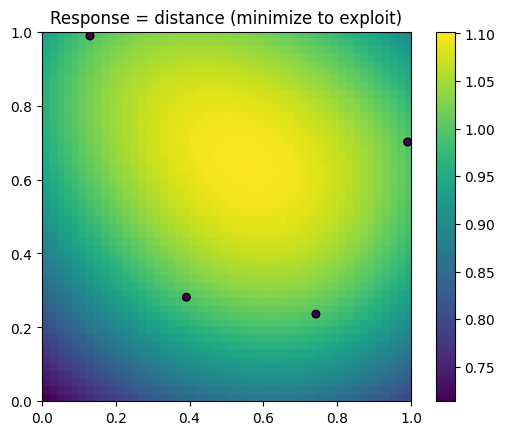

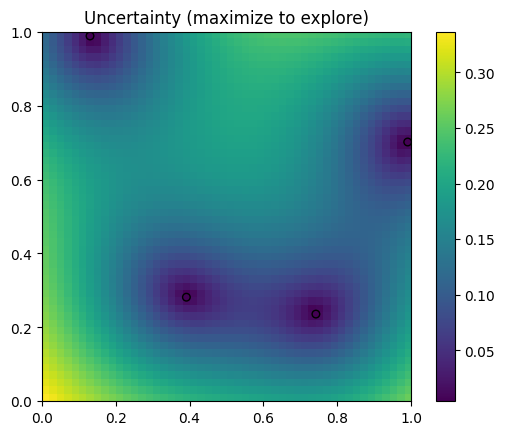

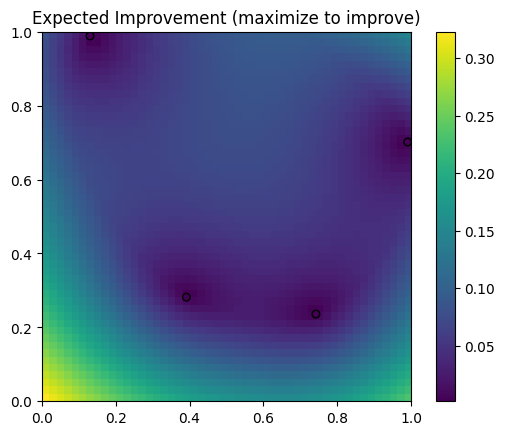

In [ ]:
# fit the and visualize the model
kernel = 1 * gp.kernels.Matern(length_scale=1.0, length_scale_bounds=(0.2, 1), nu=1.5)
model = gp.GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)
model.fit(X, y)
model.kernel_

plot_gp2d(model, X, y)

## Round 1

In [ ]:
# plan the next experiment
sol = minimize(exploit_objective, model)
sol

 message: ['Maximum number of iteration reached']
 success: True
  status: 0
     fun: 0.7139368303831817
       x: [ 0.000e+00  0.000e+00]
     nit: 1000
    nfev: 4010
    njev: 3
    nhev: 0

In [ ]:
# get the new distance from your opponent
ynew = 1

# add the new response to the dataset
X = np.vstack([X, sol.x])
y = np.append(y, ynew)
X, y

(array([[0.13066023, 0.98845491],
        [0.39139931, 0.28159114],
        [0.74184595, 0.23593237],
        [0.99019525, 0.70151603],
        [0.        , 0.        ]]),
 array([1, 1, 1, 1, 1]))

/usr/local/lib/python3.12/dist-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


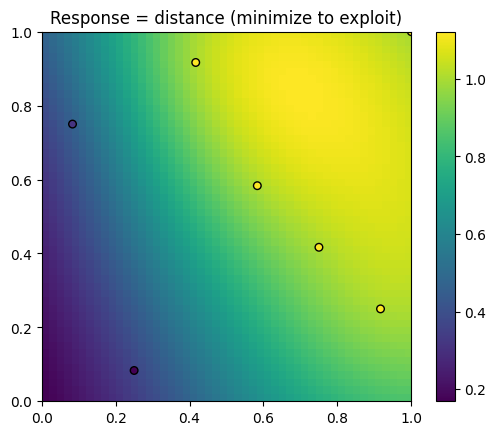

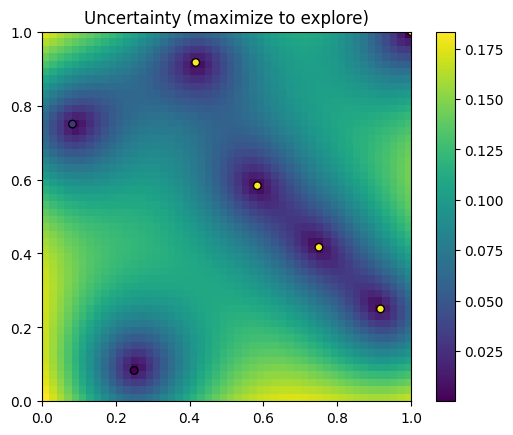

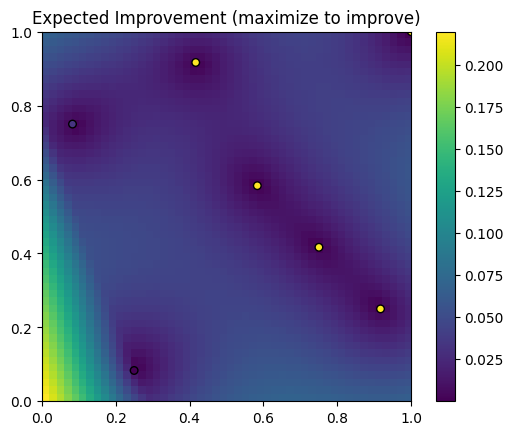

In [ ]:
# fit the and visualize the model
kernel = 1 * gp.kernels.Matern(length_scale=1.0, length_scale_bounds=(0.2, 1), nu=1.5)
model = gp.GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)
model.fit(X, y)
model.kernel_

plot_gp2d(model, X, y)

## Round 2

In [ ]:
# plan the next experiment
sol = minimize(exploit_objective, model)
sol

In [ ]:
# get the new distance from your opponent
ynew = 1

# add the new response to the dataset
X = np.vstack([X, sol.x])
y = np.append(y, ynew)
X, y

In [ ]:
# fit the and visualize the model
kernel = 1 * gp.kernels.Matern(length_scale=1.0, length_scale_bounds=(0.2, 1), nu=1.5)
model = gp.GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)
model.fit(X, y)
model.kernel_

plot_gp2d(model, X, y)

## Round 3

In [ ]:
# plan the next experiment
sol = minimize(exploit_objective, model)
sol

In [ ]:
# get the new distance from your opponent
ynew = 1

# add the new response to the dataset
X = np.vstack([X, sol.x])
y = np.append(y, ynew)
X, y

In [ ]:
# fit the and visualize the model
kernel = 1 * gp.kernels.Matern(length_scale=1.0, length_scale_bounds=(0.2, 1), nu=1.5)
model = gp.GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)
model.fit(X, y)
model.kernel_

plot_gp2d(model, X, y)

## Round 4

In [ ]:
# plan the next experiment
sol = minimize(exploit_objective, model)
sol

In [ ]:
# get the new distance from your opponent
ynew = 1

# add the new response to the dataset
X = np.vstack([X, sol.x])
y = np.append(y, ynew)
X, y

In [ ]:
# fit the and visualize the model
kernel = 1 * gp.kernels.Matern(length_scale=1.0, length_scale_bounds=(0.2, 1), nu=1.5)
model = gp.GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)
model.fit(X, y)
model.kernel_

plot_gp2d(model, X, y)

## Round 5

In [ ]:
# plan the next experiment
sol = minimize(exploit_objective, model)
sol

In [ ]:
# get the new distance from your opponent
ynew = 1

# add the new response to the dataset
X = np.vstack([X, sol.x])
y = np.append(y, ynew)
X, y

In [ ]:
# fit the and visualize the model
kernel = 1 * gp.kernels.Matern(length_scale=1.0, length_scale_bounds=(0.2, 1), nu=1.5)
model = gp.GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)
model.fit(X, y)
model.kernel_

plot_gp2d(model, X, y)

## Round 6

In [ ]:
# plan the next experiment
sol = minimize(exploit_objective, model)
sol

In [ ]:
# get the new distance from your opponent
ynew = 1

# add the new response to the dataset
X = np.vstack([X, sol.x])
y = np.append(y, ynew)
X, y

In [ ]:
# fit the and visualize the model
kernel = 1 * gp.kernels.Matern(length_scale=1.0, length_scale_bounds=(0.2, 1), nu=1.5)
model = gp.GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)
model.fit(X, y)
model.kernel_

plot_gp2d(model, X, y)